<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

###  InstitutoTecnológico y de Estudios Superiores de Occidente ###
###  Maestría Ciencia de Datos ###
###  Modelos Gráficos Probabilísticos  ###

<br>
<br>

* * *

Estudiante: Daniel Nuño <br>
Profesor: Dr. Esteban Jimenez <br>
Fecha entrega: 26 de junio, 2022<br>

* * *

<br>
<br>

# Examen 1 - Modelos probabilísticos - Práctico.

![](https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg)


Referencias:
- Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
- [Ames Housing dataset](https://www.amstat.org/publications/jse/v19n3/decock.pdf)
___

## 1. Selección de características según Lasso

Supongamos que decidimos ajustar un modelo de regresión lineal a un conjunto de datos $(X, y)$, usando la regularización tipo Lasso ($L^1$).

Un hecho ampliamente conocido es que al aumentar lo suficiente el coeficiente de regularización, algunos coeficientes se empiezan a hacer cero. Este hecho ha motivado el uso de este esquema para elegir características en el siguiente modo:

1. Se entrena el modelo para varios valores de coeficientes de regularización.
2. Se obtienen los coeficientes relativos a cada variable.
3. Los coeficientes que primero se hacen cero, son indicativo de variables "con menos poder predictivo".

A continuación un ejemplo con nuestros datos de precios de casas:

In [1]:
# Importamos librerías
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Lectura de datos
data = pd.read_csv("housing_prices.csv")
data.head()

,size,n_bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [5]:
# Entrenamos modelos para diferentes valores de coeficiente de regularización, y obtenemos coeficientes
reg_coefs = np.logspace(0, 5, 30)
coefs_size = []
coefs_nb = []
for a in reg_coefs:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Lasso(alpha=a))
    ])
    model.fit(X=data[["size", "n_bedrooms"]], y=data["price"])
    coefs_size.append(np.abs(model.named_steps["reg"].coef_[0]))
    coefs_nb.append(np.abs(model.named_steps["reg"].coef_[1]))

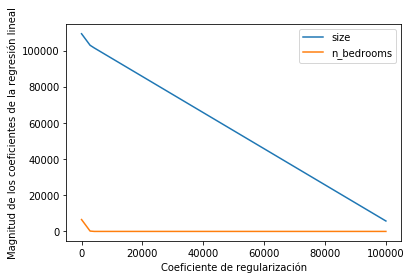

In [6]:
# Graficamos
plt.plot(reg_coefs, coefs_size, label="size")
plt.plot(reg_coefs, coefs_nb, label="n_bedrooms")
plt.xlabel("Coeficiente de regularización")
plt.ylabel("Magnitud de los coeficientes de la regresión lineal")
plt.legend()

Observamos que el coeficiente de `n_bedrooms` se hace cero bastante rápido. Por tanto, si tuviéramos que elegir solo una característica para explicar los precios de las casas, deberíamos de elegir `size`.

Usando esta idea, la aplicaremos al [conjunto de datos de calidad de vinos](https://archive.ics.uci.edu/ml/datasets/wine+quality). Leer el archivo `winequality.names`.

Variables explicativas (basadas en pruebas físico-químicas):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Variable de respuesta:

12. quality (score between 0 and 10)

Alternativamente, pueden aplicar la idea sobre [este conjunto de datos de precios de bienes raices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

Determinar:

1. El orden de poder predictivo de las variables, según Lasso.

2. Si tuvieran que elegir solo 5 variables para el modelo, ¿Cuáles elegirían?

3. Partir los datos en datos de entrenamiento y datos de prueba, y entrenar el modelo con las 5 variables seleccionadas sobre los datos de entrenamiento. ¿Cuál es el $R^2$ de su modelo?, ¿Cuál es el $R^2$ de un modelo usando todas las 11 variables explicativas? Concluir.

### 1. El orden de poder predictivo de las variables, según Lasso.

Voy a usar los datos del vino rojo de Portugal por que (¡voy a ir en agosto!) es interesante y recientemente vi una plubicación de The Pudding [Wine & Math](https://pudding.cool/2021/03/wine-model/) sobre los mismos datos.

Cada fila del dataset es un vino. La variable de respuesta es numérica discreta entre 0 y 10 en función de la mediana de los puntajes otorgados por, al menos, 3 sommeliers. 0 muy malo y 10 muy bueno. Interasantemente la calificación es sensorial, significa que el sommelier no dio una calificación directamente basado en las pruebas físico-químicas, incluso puede ser que no las conociera.

En el paper original mencionan los autores no estar seguros de la relevancia de todas la variables y que sería interesante probar con modelos de selección de variables.

Para no hacer el completo análisis exploratorio voy a citar del artículo los descubrimiento principales respecto a la importancia de las variables sobre la cálidad:

- Volatile acidity: Better wines predominantly sport lower levels and — reversely — the worse wines have the highest levels of volatile acidity, potentially impacting taste in a negative way. More clearly suggests that the lower the volatile acidity → the higher the quality in this very dataset. 
- Alcohol: higher quality wines are likely to have more alcohol in this data, as a solid proportion of especially wines around the 12-13% mark was voted good. Below 10% it’s interesting to see how few wines are deemed high quality in here.
- Variable Importance: Random Forest... algorithms will enlighten us with a ranking of which variables are most important in our predictions. 
    - Alcohol
    - Volatile acidity
    - Sulphates
    - Density
    - Citric acid
    - Chlorides
    - Total sulfur dioxide
    - Fixed acidity
    - pH
    - Residual sugar
    - Free sulfur dioxide

Veamos si Lasso nos da las mismas variables de importancia pero primero usemos t-SNE para gráficar en dos dimensiones la separación de los datos.


In [181]:
from sklearn.manifold import TSNE
# Lectura de datos
data = pd.read_csv("winequality-red.csv", delimiter=';')
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
data.quality.hist()

In [134]:
X = data.drop('quality', axis=1).to_numpy()
y = data[['quality']].to_numpy()
y_bin = y >= 6

In [137]:
tsne = TSNE(n_components=3)
Y = tsne.fit_transform(X)

c:\Users\nuno\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\nuno\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


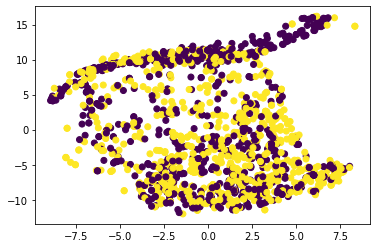

In [138]:
plt.scatter(Y[:,0], Y[:,1], c=y_bin)

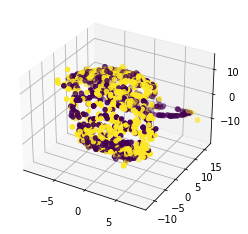

In [139]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c=y_bin)

Ok se intento pero no hay una facil separación entre un buen vino y otro malo en dos o tres dimensiones usando todas las variables.

In [133]:
print(data['quality'].median())
print(data['quality'].mean())
print(sum(y == 6) / len(y))
print(sum(y == 5) / len(y))

6.0
5.6360225140712945
[0.39899937]
[0.42589118]


Ahora regresando a Lasso

Del histograma podemos tambien apreciar que la gran mayoria de los datos se encuentran en 5 o 6, parecida a una distribución normal leptocúrtico. Pone en aprietos a la regresión lineal regularizada. Sabemos que la mediana esta en 6 y la media es 5.6 y la moda 5, por lo tanto si decimos que todos los vinos seran de calidad 6 entonces tenemos un acierto de 40%, si es 5 entonces acertamos 42%. 82% de los datos son 5 o 6. Los más probable es que la regresión por Lasso regrese únicamente el intercepto, cerca de 5.6, cuando el coeficiente de regularización sea lo suficientemente grande.

In [183]:
# Entrenamos modelos para diferentes valores de coeficiente de regularización, y obtenemos coeficientes
reg_coefs = np.linspace(0, 1, 100)
coefs_lassos = []
inter_lassos = []
for a in reg_coefs:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Lasso(alpha=a))
    ])
    model.fit(X=X, y=y)
    coefs_lassos.append(np.abs(model.named_steps["reg"].coef_))
    inter_lassos.append(np.abs(model.named_steps["reg"].intercept_))

c:\Users\nuno\Anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\nuno\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\nuno\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+02, tolerance: 1.042e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.ene

In [184]:
coefs_lassos = np.array(coefs_lassos)
inter_lassos = np.array(inter_lassos)

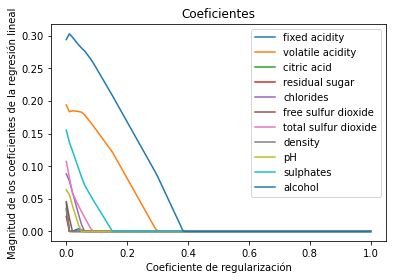

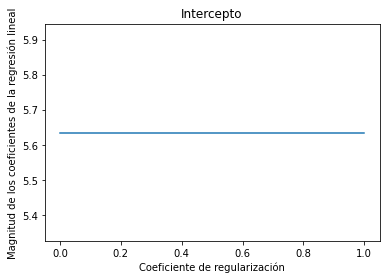

In [185]:
coefs_lassos = np.array(coefs_lassos)
inter_lassos = np.array(inter_lassos)

plt.plot(reg_coefs, coefs_lassos)
plt.xlabel("Coeficiente de regularización")
plt.ylabel("Magnitud de los coeficientes de la regresión lineal")
plt.title('Coeficientes')
plt.legend(data.drop(['quality'], axis=1).columns)
plt.show()

plt.plot(reg_coefs, inter_lassos, label='intercept')
plt.title('Intercepto')
plt.xlabel("Coeficiente de regularización")
plt.ylabel("Magnitud de los coeficientes de la regresión lineal")
plt.show()

Cerca de 0.4 ya casi todos los coeficientes son cero. El intecerpto se mantiene constante en 5.6 y como lo comentado anteriormente. El orden de la importancia de las variables es el siguiente:

In [196]:
pd.DataFrame(coefs_lassos.sum(axis=0), index=data.drop(['quality'], axis=1).columns).sort_values(by=[0], ascending=False)

,0
alcohol,6.596064
volatile acidity,3.439850
sulphates,1.054659
total sulfur dioxide,0.404903
chlorides,0.304891
pH,0.193872
free sulfur dioxide,0.066193
fixed acidity,0.052552
citric acid,0.035553
density,0.033737


Comparado con el articulo Wine & Math no obtuvimos el mismo orden de variables; solo las primeras 3.

### 2. Si tuvieran que elegir solo 5 variables para el modelo, ¿Cuáles elegirían?

- alcohol
- volatile acidity
- sulphates
- total sulfur dioxide
- chlorides

### 3. Partir los datos en datos de entrenamiento y datos de prueba, y entrenar el modelo con las 5 variables seleccionadas sobre los datos de entrenamiento. ¿Cuál es el $R^2$ de su modelo?, ¿Cuál es el $R^2$ de un modelo usando todas las 11 variables explicativas? Concluir.

In [339]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_5v = data[['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'chlorides']]
X_train, X_test, y_train, y_test = train_test_split(X_5v, y, test_size=0.3, random_state=8421)
model_5v = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

model_5v.fit(X_train, y_train)
print("$R^2$ del modelo con 5 variables usando 30 porciento de los datos de prueba es: ", model_5v.score(X_test, y_test))
print(model_5v.named_steps['reg'].intercept_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8421)
model_11v = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

model_11v.fit(X_train, y_train)
print("$R^2$ del modelo con 11 variables usando 30 porciento de los datos de prueba es: ", model_11v.score(X_test, y_test))
print(model_11v.named_steps['reg'].intercept_)

$R^2$ del modelo con 5 variables usando 30 porciento de los datos de prueba es:  0.3118408106602598
5.632707774798928
$R^2$ del modelo con 11 variables usando 30 porciento de los datos de prueba es:  0.3063348384708672
5.632707774798924


El modelo con 5 variables es ligeramente mejor. El intercepto es el mismo para ambos modelos. En conclusión si ayudo la regularización para mejorar el desepeño del modelo.

## 2. Regresión lineal Bayesiana

Usando los mismos datos de **calidad de vino o bienes raices**, aplicar la técnica de regresión lineal Bayesiana, como vimos en clase, para estimar la distribución posterior de los parámetros, suponiendo una previa normal:

$$
P(w) = \mathcal{N}(w | 0, \alpha^{-1} I),
$$

Recuerde que usted debe proponer los valores para $\alpha$ y $\beta$.

Determine:

1. La media de la distribución posterior. ¿Cuáles son los valores más probables de los parámetros?

2. La matriz de covarianza de la distribución posterior.

3. Simular 1000 valores conjuntos de los parámetros, y calcular la estimación de calidad con cada uno de ellos para los siguientes valores:

| fixed acidity | volatile acidity | citric acid | residual sugar | chlorides | free sulfur dioxide | total sulfur dioxide | density | pH | sulphates | alcohol |
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 7.4   | 0.7   | 0     | 1.9   | 0.076 | 11    | 34    | 0.9978| 3.51  | 0.56 	| 9.4   |

   - ¿Cuál es la calidad máxima estimada?, ¿Cuál es el percentil 95%?
   - ¿Cuál es la calidad mínima estimada?, ¿Cuál es el percentil 5%?

### 1. La media de la distribución posterior. ¿Cuáles son los valores más probables de los parámetros?

In [306]:
from scipy import stats

N = len(data)
sigma = X.std()
Phi = np.concatenate((np.ones((N,1)), X.reshape((N,11))), axis=1)
Phi

array([[ 1.   ,  7.4  ,  0.7  , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 1.   ,  7.8  ,  0.88 , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 1.   ,  7.8  ,  0.76 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 1.   ,  6.3  ,  0.51 , ...,  3.42 ,  0.75 , 11.   ],
       [ 1.   ,  5.9  ,  0.645, ...,  3.57 ,  0.71 , 10.2  ],
       [ 1.   ,  6.   ,  0.31 , ...,  3.39 ,  0.66 , 11.   ]])

In [334]:
# Gamma
gamma = 350
# Distribución posterior
lambda_ = sigma**2 / gamma**2
w_map = np.linalg.inv(Phi.T.dot(Phi) + lambda_ * np.eye(12)).dot(Phi.T.dot(y))
Sigma = sigma**2 * np.linalg.inv(Phi.T.dot(Phi) + lambda_ * np.eye(12))
posterior = stats.multivariate_normal(mean=w_map.reshape(12), cov=Sigma)

print(np.round(posterior.mean,2))

[ 5.56  0.01 -1.1  -0.18  0.01 -1.9   0.   -0.   -1.14 -0.5   0.89  0.29]


Los valores más probables son los mostrados arriba.

### La matriz de covarianza de la distribución posterior.

La covarianza es la siguiente matrix triangular de dimensiones 12 x 12.

In [338]:
print(posterior.cov)

[[ 5.00397598e+04  4.54428256e+01  3.69680976e+01  5.16877915e+00
   2.11095911e+01  6.39446903e+01 -3.90909514e-01  9.08274623e-02
  -5.09452760e+04  2.23244643e+02  6.58482278e+01 -4.78586457e+01]
 [ 4.54428256e+01  2.21378880e-01 -2.78759137e-01 -8.63393505e-01
   1.14835676e-02  1.26659001e+00 -2.07961847e-03  2.30204402e-03
  -5.09019733e+01  1.17080214e+00 -1.70266751e-02 -2.36558552e-02]
 [ 3.69680976e+01 -2.78759137e-01  9.63474660e+00  6.34452194e+00
  -4.81185095e-02 -9.24639805e+00  3.05387955e-02 -1.30581800e-02
  -3.72434702e+01 -1.34043432e+00  1.68641553e+00  4.79874702e-03]
 [ 5.16877915e+00 -8.63393505e-01  6.34452194e+00  1.44277124e+01
  -8.54916202e-02 -1.08585569e+01  3.47281263e-02 -1.89704320e-02
  -1.51865314e+00  5.61797598e-01 -3.20639783e-01 -3.72485700e-01]
 [ 2.11095911e+01  1.14835676e-02 -4.81185095e-02 -8.54916202e-02
   1.05662996e-01 -1.41056511e-01 -1.83902425e-03 -5.36094209e-04
  -2.14586183e+01  9.68221289e-02  8.90933322e-02 -3.34673857e-02]
 [ 6.

### 3. Simular 1000 valores conjuntos de los parámetros, y calcular la estimación de calidad con cada uno de ellos para los siguientes valores:

In [355]:
bayes_test = [1, 7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4]
w_samples = posterior.rvs(size=1000)

In [359]:
est = []
for i in w_samples:
    est.append(i.dot(bayes_test))

est = np.array(est)

¿Cuál es la calidad máxima estimada?, ¿Cuál es el percentil 95%?

In [361]:
est.max(), np.percentile(est, 95)

(7.853466412019394, 6.702149554276462)

¿Cuál es la calidad mínima estimada?, ¿Cuál es el percentil 5%?

In [362]:
est.min(), np.percentile(est, 5)

(1.5277607851456834, 3.2738855829047377)

## Referencia

- Diehm, J., & Verspohl, L. (2021, March 21). Wine & Math: A model pairing. The Pudding. Retrieved June 26, 2022, from https://pudding.cool/2021/03/wine-model/

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>